**IEEE BigData 2024: EMPWR Lab Session 12/17/2024**

The Process of Turning an Unstructured Data Input to KGs

**Framework**

1. Data Ingestion & Extraction
2. Search and Integration of Existing Knowledge Bases
3. Knowledge Enrichment (Data Uplifting) & Linking
4. Subgraph Creations
5. Schema Inference, Generation, and Alignment

### 1. Data Ingestion & Extraction with LLMs

In [ ]:
# Load the Transformer-based Large Language Model: REBEL
# https://github.com/Babelscape/rebel

from transformers import pipeline

triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')

# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [ ]:
# Our qa_text
qa_text = "How does methotrexate treat rheumatoid arthritis?"

# Perform triple extraction
extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(qa_text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])
extracted_triplets = extract_triplets(extracted_text[0])
print(json.dumps(extracted_triplets,sort_keys=False, indent=4))

[
    {
        "head": "methotrexate",
        "type": "medical condition treated",
        "tail": "rheumatoid arthritis"
    },
    {
        "head": "rheumatoid arthritis",
        "type": "drug used for treatment",
        "tail": "methotrexate"
    }
]


#### Create Seed KG

In [ ]:
import json
import datetime
now = str(datetime.datetime.now())

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

source = "REBEL"
triples = []
entities = []
relations = []

for triplet in extracted_triplets:
  # Quintuple format
  # head, relation, tail, source, time
  triples.append({
      "head": triplet["head"],
      "relation": triplet["type"],
      "tail": triplet["tail"],
      "source": source,
      "createdAt": now
  })
  entities.append(triplet["head"])
  entities.append(triplet["tail"])
  relations.append(triplet["type"])

# Get unique list of entities & relations
entities = set(entities)
relations = set(relations)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(json.dumps(triples,sort_keys=False, indent=4))

[
    {
        "head": "methotrexate",
        "relation": "medical condition treated",
        "tail": "rheumatoid arthritis",
        "source": "REBEL",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "rheumatoid arthritis",
        "relation": "drug used for treatment",
        "tail": "methotrexate",
        "source": "REBEL",
        "createdAt": "2024-12-05 00:54:25.153448"
    }
]


In [ ]:
for entity in entities:
  print(entity)

methotrexate
rheumatoid arthritis


In [ ]:
for relation in relations:
  print(relation)

drug used for treatment
medical condition treated


### 2. Search and Integration of Existing Knowledge Bases

More at: https://github.com/Joeyipp/KExtractor

In [ ]:
# Install pre-requisites and libraries
!pip install spacy==3.5
!pip install spacy-dbpedia-spotlight
!pip install spacy-entity-linker
!pip install wikidata
!pip install rdflib
!pip install SPARQLWrapper
!pip install networkx matplotlib

!python -m spacy download en_core_web_md
!python -m spacy_entity_linker "download_knowledge_base" # Wikidata

In [ ]:
import spacy  # version 3.5'

# initialize language model
nlp = spacy.load("en_core_web_md")

# add pipeline (declared through entry_points in setup.py)
nlp.add_pipe("entityLinker", last=True)

#### Entity Linking with WikiData

In [ ]:
doc = nlp(",".join(entities))

# returns all entities in the whole document
all_linked_entities = doc._.linkedEntities
wikiData_ID = []

source = "WikiData"
#iterates over sentences and prints linked entities
for sent in doc.sents:
    # sent._.linkedEntities.pretty_print()
    # Get LinkedEntities info

    for ent in sent._.linkedEntities:
      res = {
          "head": ent.get_label(),
          "relation": "WikiData_ID",
          "tail": "Q{}".format(ent.get_id()),
          "source": source,
          "createdAt": now
      }
      wikiData_ID.append("Q{}".format(ent.get_id()))
      triples.append(res)

print(json.dumps(triples,sort_keys=False, indent=4))

[
    {
        "head": "methotrexate",
        "relation": "medical condition treated",
        "tail": "rheumatoid arthritis",
        "source": "REBEL",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "rheumatoid arthritis",
        "relation": "drug used for treatment",
        "tail": "methotrexate",
        "source": "REBEL",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "methotrexate",
        "relation": "WikiData_ID",
        "tail": "Q422232",
        "source": "WikiData",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "rheumatoid arthritis",
        "relation": "WikiData_ID",
        "tail": "Q187255",
        "source": "WikiData",
        "createdAt": "2024-12-05 00:54:25.153448"
    }
]


### 3. Knowledge Enrichment (Data Uplifting)

In [ ]:
# Linking with WikiData
from SPARQLWrapper import SPARQLWrapper, JSON

# Define the Wikidata SPARQL endpoint
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

# Function to get the label for a given Wikidata URI
def get_wikidata_label(wikidata_uri):
    # Set up the SPARQL endpoint for Wikidata
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

    # Define the SPARQL query to get the label for the given Wikidata URI
    query = f"""
    SELECT ?label WHERE {{
      wd:{wikidata_uri} rdfs:label ?label.
      FILTER(LANG(?label) = "en")
    }}
    """

    # Set the query and return format
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    # Execute the query and get the results
    try:
        results = sparql.query().convert()
        if results["results"]["bindings"]:
            # If results are found, return the label
            label = results["results"]["bindings"][0]["label"]["value"]
            return label
        else:
            return None
    except Exception as e:
        print(f"Error querying Wikidata: {e}")
        return None

for item_id in wikiData_ID:
    sparql.setQuery(f"""
    SELECT ?property ?propertyLabel ?value ?valueLabel WHERE {{
      wd:{item_id} ?property ?value.  # Query for properties and values of the specified item
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}  # Fetch labels in English
    }}
    LIMIT 5
    """)

    # Set the return format to JSON
    sparql.setReturnFormat(JSON)

    # Execute the query and store the results
    results = sparql.query().convert()

    source = "WikiData"
    # Process and print the results
    for result in results["results"]["bindings"]:
        res = {
          "head": item_id,
          "relation": get_wikidata_label(result["propertyLabel"]["value"].split("/")[-1]),
          "tail": result["valueLabel"]["value"],
          "source": source,
          "createdAt": now
        }
        triples.append(res)

#### Enriched KG

In [ ]:
print(json.dumps(triples,sort_keys=False, indent=4))

[
    {
        "head": "methotrexate",
        "relation": "medical condition treated",
        "tail": "rheumatoid arthritis",
        "source": "REBEL",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "rheumatoid arthritis",
        "relation": "drug used for treatment",
        "tail": "methotrexate",
        "source": "REBEL",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "methotrexate",
        "relation": "WikiData_ID",
        "tail": "Q422232",
        "source": "WikiData",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "rheumatoid arthritis",
        "relation": "WikiData_ID",
        "tail": "Q187255",
        "source": "WikiData",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Q422232",
        "relation": "chemical formula",
        "tail": "C\u2082\u2080H\u2082\u2082N\u2088O\u2085",
        "source": "WikiData",
        "createdAt": "2024-12-05 

### 4. Subgraph Creations

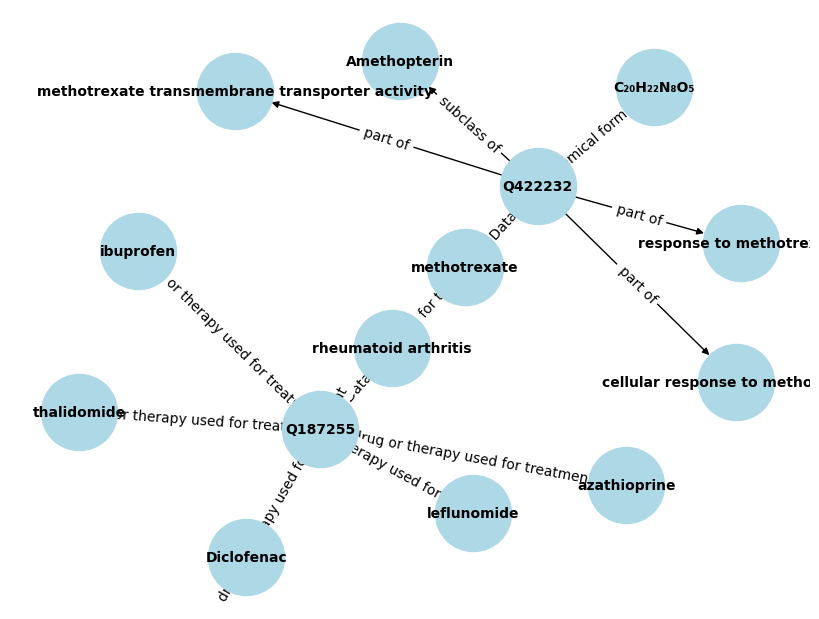

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def create_Graph(data):
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph from the input data
    for head, relation, tail in data:
        G.add_edge(head, tail, label=relation)

    # Plot the graph with labels
    pos = nx.spring_layout(G)  # Layout for positioning nodes
    plt.figure(figsize=(8, 6))

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)

    # Add edge labels (relations)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Show the plot
    plt.show()

# 3 columns: head, relation, tail
data = []
for triple in triples:
    data.append(tuple([triple["head"], triple["relation"], triple["tail"]]))

create_Graph(data)

### 5. Schema Inference and Generation

In [ ]:
!pip install flair

In [ ]:
# Load the Entity Tagger with HunFlair
# https://github.com/flairNLP/flair/blob/master/resources/docs/HUNFLAIR2.md

from flair.data import Sentence
from flair.nn import Classifier

# load biomedical tagger
tagger = Classifier.load("hunflair2")

2024-12-05 00:56:08,398 SequenceTagger predicts: Dictionary with 21 tags: O, S-Chemical, B-Chemical, E-Chemical, I-Chemical, S-Gene, B-Gene, E-Gene, I-Gene, S-Disease, B-Disease, E-Disease, I-Disease, S-Species, B-Species, E-Species, I-Species, S-CellLine, B-CellLine, E-CellLine, I-CellLine


In [ ]:
# make a sentence
sentence = Sentence("methotrexate")
# tag sentence
tagger.predict(sentence)

for entity in sentence.get_labels():
    label = str(entity).split("→")[-1].split("(")[0]

#### Schema Generation

In [ ]:
inferred_schema = []

source = "Hunflair2"

for triple in triples:
    head_label = ""
    tail_label = ""

    head_entity = triple["head"]
    tail_entity = triple["tail"]

    # Schema inference
    tagger.predict(Sentence(head_entity))
    for head_entity in sentence.get_labels():
        head_entity_label = str(entity).split("→")[-1].split("(")[0]

    tagger.predict(Sentence(tail_entity))
    for tail_entity in sentence.get_labels():
        tail_entity_label = str(entity).split("→")[-1].split("(")[0]

    # Schema generation
    inferred_schema.append({
        "head": head_entity_label.strip(),
        "relation": triple["relation"],
        "tail": tail_entity_label.strip(),
        "source": source,
        "createdAt": now
    })

# Filter unique schemas
inferred_schema = [dict(t) for t in {tuple(d.items()) for d in inferred_schema}]

##### KG Instances

In [ ]:
# KG Instances
print(json.dumps(triples,sort_keys=False, indent=4))

[
    {
        "head": "methotrexate",
        "relation": "medical condition treated",
        "tail": "rheumatoid arthritis",
        "source": "REBEL",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "rheumatoid arthritis",
        "relation": "drug used for treatment",
        "tail": "methotrexate",
        "source": "REBEL",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "methotrexate",
        "relation": "WikiData_ID",
        "tail": "Q422232",
        "source": "WikiData",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "rheumatoid arthritis",
        "relation": "WikiData_ID",
        "tail": "Q187255",
        "source": "WikiData",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Q422232",
        "relation": "chemical formula",
        "tail": "C\u2082\u2080H\u2082\u2082N\u2088O\u2085",
        "source": "WikiData",
        "createdAt": "2024-12-05 

##### KG Schema

In [ ]:
# KG Schema
print(json.dumps(inferred_schema,sort_keys=False, indent=4))

[
    {
        "head": "Chemical",
        "relation": "WikiData_ID",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "subclass of",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "drug used for treatment",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "chemical formula",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "medical condition treated",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        

#### Schema Alignment with WordNet (WN)

In [ ]:
schema_entities = []

for schema in inferred_schema:
    if schema["head"] not in schema_entities:
       schema_entities.append(schema["head"])
    if schema["tail"] not in schema_entities:
       schema_entities.append(schema["tail"])

for entity in schema_entities:
    syns = wn.synonyms(entity)[0]

    for syn in syns:
        inferred_schema.append({
            "head": entity,
            "relation": "synonyms",
            "tail": syn,
            "source": "WN",
            "createdAt": now
        })

In [ ]:
# Filter unique schemas
inferred_schema = [dict(t) for t in {tuple(d.items()) for d in inferred_schema}]

# Print inferred schema
print(json.dumps(inferred_schema,sort_keys=False, indent=4))

[
    {
        "head": "Chemical",
        "relation": "WikiData_ID",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "subclass of",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "drug used for treatment",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "synonyms",
        "tail": "chemical",
        "source": "WN",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "chemical formula",
        "tail": "Chemical",
        "source": "Hunflair2",
        "createdAt": "2024-12-05 00:54:25.153448"
    },
    {
        "head": "Chemical",
        "relation": "medical con

### With both KG Instances and KG Schema, you can export them to 3rd party Graph Databases such as Neo4j or train KG embedding models such as TransE, etc for your downstream tasks and applications!